In [1]:
# 라이브러리 호출
import bok_da as bd
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns

#### 본 사용자 매뉴얼에서는 일반화된 충격반응함수(Generalized IRF)에 대한 내용을 다룬다.

## 1. 데이터 불러오기
- 작성자: 고려대학교 경제학과 강규호 교수, 디지털신기술팀 이창훈 과장

데이터는 한국의 전기대비 실질 GDP 성장률, CD91일 금리, 인플레이션율 소비자 가격 지수 (Consumer Price Index, CPI), CD91일 금리로 1999년 4분기부터 2023년 4분끼지의 분기별 자료이다. 해당 데이터는 ECOS (https://ecos.bok.or.kr/#/)에서 다운로드 받았으며 컴퓨터에 "python_data.xlsx"라는 이름의 엑셀파일의 "KORmacro"라는 시트에 저장되어 있다. 이때, 인플레이션율의 경우 소비자 가격 지수 (Consumer Price Index, CPI)의 전년동기대비 치분 (YoY)을 통해 미리 변환한 것이다.

`data` 폴더에서 `python_data.xlsx`를 불러온 후 파이썬 표준 자료형인 `pandas.DataFrame`으로 전처리를 수행한다. `DataFrame`은 테이블 형태의 데이터의 행(날짜)과 열(변수명) 정보를 가지고 있어, 행렬이나 벡터형태로 분석하는 것보다 유용하다. `df`라는 이름으로 할당하는 것이 일반적이다. 데이터프레임에 익숙하지 않은 경우 아래 셀의 코드를 줄별로 여러 셀로 나누어 실행해보는 것을 추천한다. 원천기관에서 raw 데이터를 불러오고 전처리하는 과정이 복잡해 보일 수 있지만, 한번 해두면 크게 코드를 수정할 필요없이 새로운 데이터에 대해서도 분석 가능한 형태로 전처리 할 수 있기 때문에 장기적으로 효율적인 방법이다.

In [2]:
df = pd.read_excel('data/python_data.xlsx', sheet_name='KORmacro') # 데이터 엑셀파일 불러오기
df = df.set_index('date') # date 명의 열을 인덱스로 지정한다.
df.index.name = None # 인덱스 이름 date를 제거한다.
df.index = df.index.str.replace('/', '-') # 2000/03 형식을 pandas가 날짜로 인식하도록 2000-3형식으로 변환한다.
df.index = pd.to_datetime(df.index) + pd.offsets.QuarterEnd(0) # 인덱스(행)를 날짜로 인식하도록 변환한다.
df.index.freq = pd.offsets.QuarterEnd() # 인덱스의 frequency를 분기말(2000-03-31)로 설정한다.
column_order = ['inf', 'rgdp', 'cd91'] # df의 열 순서를 리스트로 미리 할당
df = df[column_order] # df의 열 순서를 column_order에 맞게 변경
df

,inf,rgdp,cd91
2000-12-31,2.508257,-0.3,6.97
2001-03-31,3.627876,1.2,5.95
2001-06-30,4.919778,1.3,5.78
2001-09-30,4.158456,1.4,4.97
2001-12-31,3.244327,1.8,4.58
...,...,...,...
2022-12-31,5.083054,-0.3,3.91
2023-03-31,4.496285,0.3,3.64
2023-06-30,3.212650,0.6,3.63
2023-09-30,3.079117,0.6,3.74


## 2. 일반화된 충격반응함수 (Generalized IRF)

`bok_da` 라이브러리 시계열분석 패키지(`ts`)의 VAR모형 서브패키지(`var`)에 있는 `var_girf_bootstrap` 함수를 사용하면 VAR(p) 모형의 일반화된 충격반응함수 및 부트스트래핑을 통한 충격반응함수 신뢰구간을 도출할 수 있다. 일반화된 충격반응함수에 대한 자세한 내용은 매뉴얼 제일 아래 셀의 `(참고)`를 참조.

$y_{t}=(inf_{t}\text{, }\Delta rgdp_{t}\text{, }int_{t})^{\prime}$라는 반응변수 벡터를 사용하여 VAR(p) 모형의 일반화된 충격반응함수와 부트스트래핑으로 추정한 일반화된 충격반응함수의 신뢰구간을 도출한다. 이때, BIC로 추정한 VAR(p) 모형의 최적 시차는 `p.bic=2`이고, 충격반응함수 추정을 위해 총 20기 이후까지를 예측한다고 하자. 나아가 부트스트래핑으로 일반화된 충격반응함수의 95\% 신뢰구간을, 총 2000번의 반복을 통해 추정한다고 하자.

In [3]:
from bok_da.ts.var import var_girf_bootstrap, order_var

In [4]:
p = order_var(df, lag_max=4)

`var_girf_bootstrap` 함수는 `data`(데이터), `lag`(시차), `h`(충격반응함수 기간), `q`(quantile), `n`(부트스트랩 횟수)을 인자로 갖는다. 이 중 `data`를 제외한 모든 인자는 기본값(default)을 갖는다. 다음 셀과 같이 df만 입력하는 경우 나머지 인자는 기본값을 기준으로 추정된다.

In [6]:
res = var_girf_bootstrap(df, lag=p.bic, h=20, q=95) # by default: n=2000

res 인스턴스는 다음의 결과를 포함한다.
</br>
    `theta`: 추정된 VAR(p) 모형의 충격반응함수
    </br>
    `cilv`: 충격반응함수 신뢰구간의 하한
    </br>
    `cihv`: 충격반응함수 신뢰구간의 상한
    </br>
    `cum_theta`: 추정된 VAR(p) 모형의 누적된 충격반응함수
    </br>
    `cum_cilv`: 누적된 충격반응함수 신뢰구간의 하한
    </br>
    `cum_cihv`: 누적된 충격반응함수 신뢰구간의 상한
    </br>

res 인스턴스의 `plot_irf` 메서드를 이용해 일반화된 충격반응함수를 그릴 수 있다.

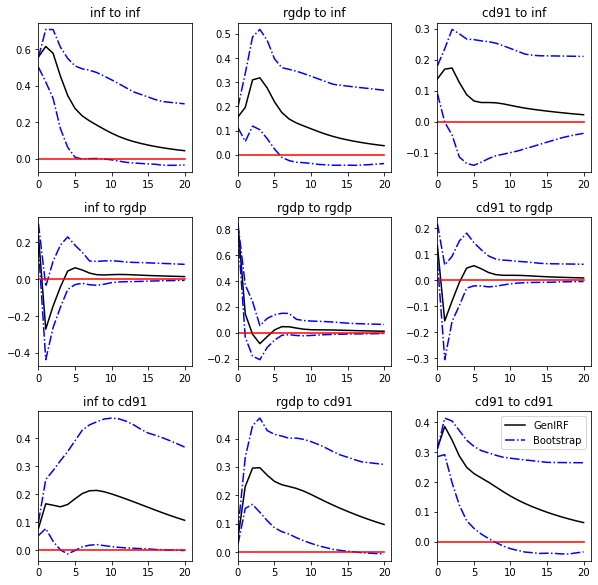

In [7]:
res.plot_irf(title=False)

`cum=True`로 설정할 경우, 일반화된 누적충격반응함수를 출력한다.

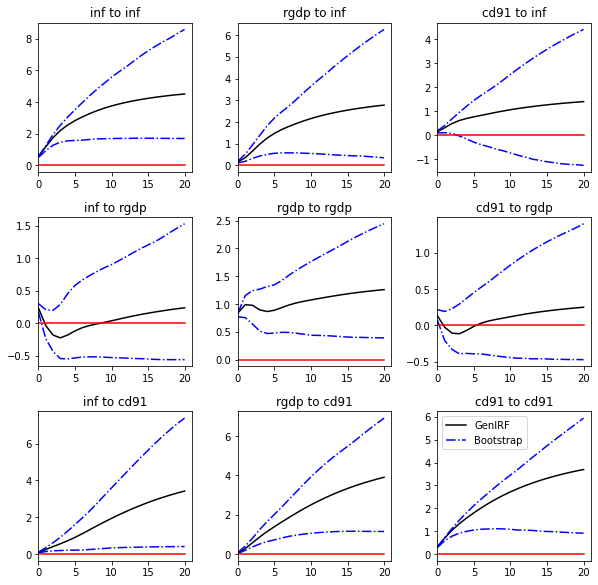

In [8]:
res.plot_irf(cum=True, title=False)

참고로, `VectorAutoRegression` 클래스를 이용해서도 추정할 수 있다. `var` 서브패키지에서 `VectorAutoRegression` 클래스를 `VAR`로 불러와 사용한다.

In [9]:
from bok_da.ts.var import VectorAutoRegression as VAR

`VAR` 클래스를 이용해 `model`을 설정하고, `fit` 메서드를 이용해 추정한다. `irf=None`이거나 인자를 입력하지 않는 경우, 축약형 VAR(p) 모형 추정치를 리턴한다. irf를 'generalized'로 입력하면 모형 추정치와 일반화된 충격반응함수 추정치를 리턴한다. `var_girf_bootstrap` 함수와 동일하게 인자를 직접 입력할 수 있다.

In [10]:
model = VAR(lag=p.bic)
res = model.fit(df, irf='generalized', h=20, q=95)

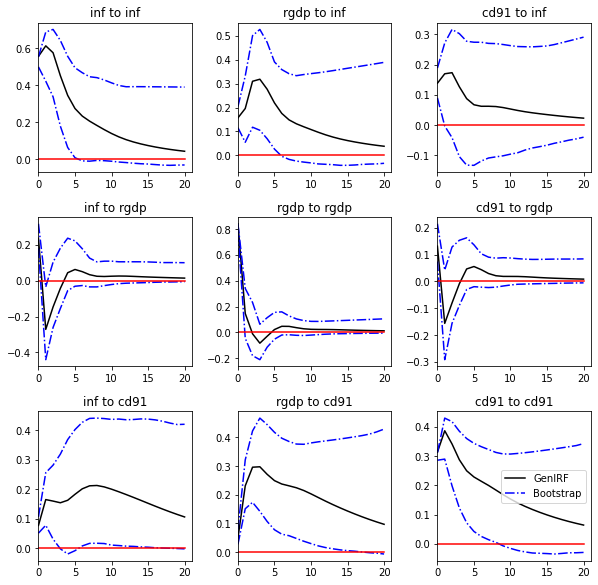

In [11]:
res.plot_irf(title=False)

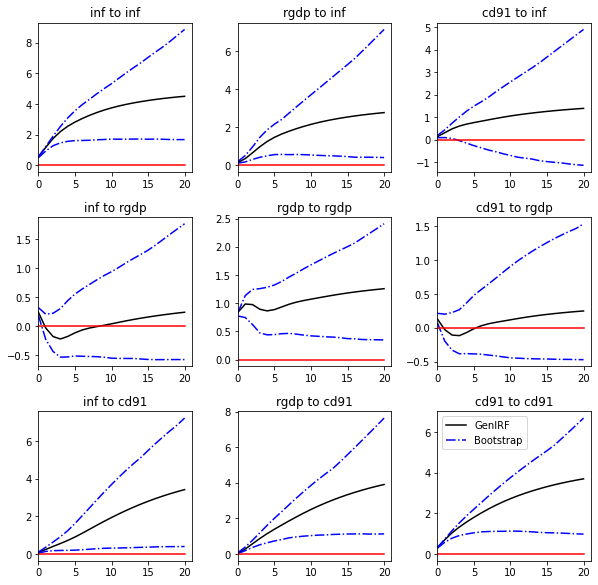

In [12]:
res.plot_irf(cum=True, title=False)

### (참고) 일반화된 충격반응함수
Pesaran and Shan (1998)에서 처음 제안된 일반화된 충격반응함수 (Generalized Impulse Response Function)는 연구자의 목적이 VAR 모형을 사용한 예측이거나 축약형 충격에 대한 반응변수들의 반응을 보는 것일 때 사용된다. 이때, 축약형 충격을 사용하기 때문에 축약형 모형을 추정한 이후, 이전과 같이 구조형 충격을 식별하기 위한 별도의 식별 절차가 필요하지 않다는 것이 특징이다.

우선, 다음과 같은 축약형 VAR 모형을 생각해보자.
\begin{align}
    y_{t} & = A(L)^{-1}u_{t} = \Psi(L)u_{t}\text{, }u_{t}\sim WN(0,\Sigma) \notag \\
    & = u_{t} + \Psi_{1}u_{t-1} + \Psi_{2}u_{t-2} + \cdots \tag{1}
\end{align}

$I_{t-1}$을 $t-1$ 시점까지 알려진 변수들의 정보라고 하자. 그럼 우리의 목적은 $I_{t-1}$이 주어질 때, $t$기의 특정 축약형 충격 $u_{t}=\delta$이 $y_{t+h}$ 변수에 미치는 영향으로 정의된 일반화된 충격반응함수를 보는 것이다. 이를 수식으로 표현하면 다음과 같다.
\begin{equation}
    GI(h,\delta,I_{t-1}) = \mathbb{E}(y_{t+h}|u_{t}=\delta\text{,}I_{t-1})-\mathbb{E}(y_{t+h}|I_{t-1}) \tag{2}
\end{equation}

식 (1)을 사용하여 식 (2)의 우변의 각 항을 
\begin{align}
    & y_{t+h} = \underbrace{u_{t+h}+\Psi_{1}u_{t+h-1}+\Psi_{2}u_{t+h-2}+\cdots+\Psi_{h-1}u_{t+1}}_{\text{정보집합에 포함되지 않은 부분}}+\underbrace{\Phi_{h}u_{t}+\Psi_{h+1}u_{t-1}+\cdots}_{\text{정보집합에 포함된 부분}} \notag \\
    & \Rightarrow \mathbb{E}(y_{t+h}|I_{t-1})=0 + \mathbb{E}(\Psi_{h}u_{t}+\Psi_{h-1}u_{t-1}+\cdots|I_{t-1}) \notag
\end{align}
그리고
\begin{equation}
    \mathbb{E}(y_{t+h}|u_{t}=\delta\text{, }I_{t-1}) = 0 + \mathbb{E}(\Psi_{h}\delta+\Psi_{h+1}u_{t-1}+\cdots|I_{t-1}) \notag
\end{equation}
와 같이 표현할 수 있다. 따라서, 우리가 목적으로 하는 일반화된 충격반응함수는 다음과 같이 표현된다.
\begin{equation}
    GI(h,\delta,I_{t-1}) = \Psi_{h}\cdot\delta \notag
\end{equation}

Pesaran and Shin (1998)는 $\delta$를 구성하고 있는 한 개의 구조충격만 변화하는 경우, 즉 $u_{it}=\delta_{i}$인 경우를 고려하였다. 그 결과, 일반화된 충격반응함수는 다음과 같이 수정되어 표현될 수 있다.
\begin{align}
    GI(h,\delta_{i},I_{t-1}) & = \mathbb{E}(y_{t+h}|u_{it}=\delta_{i}\text{, }I_{t-1}) - \mathbb{E}(y_{t+h}|I_{t-1}) \notag \\
    & = \Psi_{h}\mathbb{E}(u_{t}|u_{it}=\delta_{i}\text{, }I_{t-1}) \notag
\end{align}
$u_{t}$가 다변량 정규분포를 따른다고 가정하면, $u_{it}=\delta_{i}$가 주어질 경우 $u_{t}$의 조건부 기댓값은 다음과 같이 표현될 수 있다.
\begin{align}
    \mathbb{E}(u_{t}|u_{it}=\delta_{i}\text{, }I_{t-1}) = \begin{pmatrix}
        \mathbb{E}(u_{1t}|u_{it}) \\
        \vdots \\
        \mathbb{E}(u_{nt}|u_{it})
    \end{pmatrix} & = \begin{pmatrix}
        \sigma_{1i} \\
        \vdots \\
        \sigma_{ni}
    \end{pmatrix}\cdot\frac{\delta_{i}}{\sigma_{ii}} \notag \\
    & = \Sigma_{\mathrm{1}_{i}}\cdot\frac{\delta_{i}}{\sigma_{ii}} \notag
\end{align}
이때, $\sigma_{ij}$는 축약형 충격 $u_{t}$들의 분산-공분산 행렬 $\Sigma$의 (i,j) 번째 원소를 의미한다. $\delta=\sqrt{\sigma_{ii}}$라고 가정하면, 일반화된 충격반응함수는 다음과 같이 표현할 수 있다.
\begin{align}
    GI(h,\delta_{i},I_{t-1}) & = \Phi_{h}\cdot\begin{pmatrix}
        \Sigma_{\mathrm{1}_{1}}\cdot\sigma_{11}^{-\frac{1}{2}} \notag \\
        \vdots \\
        \Sigma_{\mathrm{1}_{n}}\cdot\sigma_{nn}^{-\frac{1}{2}}
    \end{pmatrix} \notag \\
    & = \begin{pmatrix}
        \Phi_{h}\Sigma_{\mathrm{1}_{1}} \\
        \vdots \\
        \Phi_{h}\Sigma_{\mathrm{1}_{n}}
    \end{pmatrix}\cdot diag(\sigma_{11}^{-\frac{1}{2}},\cdots,\sigma_{nn}^{-\frac{1}{2}}) \notag \\
    & = \Phi_{h}\cdot\Sigma\cdot diag(\sigma_{11}^{-\frac{1}{2}},\cdots,\sigma_{nn}^{-\frac{1}{2}}) \notag \\
    & = \Phi_{h}\cdot(\Sigma_{\mathrm{1}_{i}})\cdot\frac{1}{\sqrt{\sigma_{ii}}} \notag
\end{align}
이때, $u_{it}$가 $\sqrt{\sigma_{ii}}$만큼 변화한다는 것이 유일한 충격의 변화분이기 때문에, 일반화된 충격반응함수는 $h$기 이후의 설명변수들에 대한 1 표준편차 충격의 영향을 의미한다.
